In [1]:
import numpy
import pandas

import json

from matplotlib import pyplot as plt

from helpers import network, plotting

In [5]:
# FILL IN TARGET CONFIG FILE!
with open("configs/microns_placement_7.json", "r") as fid:
    cfg = json.load(fid)

plot_out = cfg["plotting"]["output_root"]
save_out = cfg["save"]["filename"]
save_id = cfg["save"]["id"]

M = network.load_network(cfg["connectome"]["loading"])

{'connectome': {'cols_xyz': ['x_nm', 'y_nm', 'z_nm'], 'loading': {'conntility': '/scratch/datasets/microns_reimann/microns_mm3_connectome.h5', 'args': ['condensed']}, 'subnetwork': {'base_volume': [], 'simplices': [{'column': 'cell_type', 'function': 'isin', 'args': [['23P', '4P', '6CT', '5P_IT', '5P_PT', '5P_NP', '6IT']]}, {'column': 'x_nm', 'function': 'gt', 'args': [700000.0]}, {'column': 'x_nm', 'function': 'lt', 'args': [1200000.0]}, {'column': 'z_nm', 'function': 'gt', 'args': [700000.0]}, {'column': 'z_nm', 'function': 'lt', 'args': [1000000.0]}], 'neurons': {'name': 'Inhibitory', 'filters': [{'column': 'cell_type', 'function': 'isin', 'args': [['BC', 'MC', 'NGC']]}]}}}, 'analysis': {'simplex_dimension': 6, 'use_weight': 0, 'min_degrees': {'In': 200, 'Out': 200}, 'normalize_mat': 0, 'clustering': {'use': 'source', 'cluster_param': 2.2, 'merge_smaller_than': 0.05, 'normalize_cluster_paths': 'pairs', 'normalize_cluster_disyn': 'pairs', 'cutoff': {'strategy': 'percentile_control', 

{'connectome': {'cols_xyz': ['x_nm', 'y_nm', 'z_nm'],
  'loading': {'conntility': '/home/reimann/Documents/data/microns/microns_mm3_connectome_v1181.h5',
   'args': ['condensed']},
  'subnetwork': {'base_volume': [],
   'simplices': [{'column': 'cell_type',
     'function': 'isin',
     'args': [['23P', '4P', '6CT', '5P_IT', '5P_PT', '5P_NP', '6IT']]},
    {'column': 'x_nm', 'function': 'gt', 'args': [700000.0]},
    {'column': 'x_nm', 'function': 'lt', 'args': [1200000.0]},
    {'column': 'z_nm', 'function': 'gt', 'args': [700000.0]},
    {'column': 'z_nm', 'function': 'lt', 'args': [1000000.0]}],
   'neurons': {'name': 'Inhibitory',
    'filters': [{'column': 'cell_type',
      'function': 'isin',
      'args': [['BC', 'MC', 'NGC']]}]}}},
 'analysis': {'simplex_dimension': 6,
  'use_weight': 0,
  'min_degrees': {'In': 200, 'Out': 200},
  'normalize_mat': 0,
  'clustering': {'use': 'source',
   'cluster_param': 2.2,
   'merge_smaller_than': 0.05,
   'normalize_cluster_paths': 'pairs',

In [6]:
from scipy.spatial import distance

M.vertices["cell_type"].value_counts()

cols_pos = ["x_nm", "y_nm", "z_nm"]
grp_pc = ["L3b", "L2c", "L3a", "L2b", "L2a"]
grp_inh = ["PTC", "DTC", "ITC", "STC"]

def sample_pairs_within(grp_a, grp_b, dist_max):
    sub_a = M.index("status_axon").eq("t").index("cell_type").isin(grp_a)
    sub_b = M.index("status_axon").eq("t").index("cell_type").isin(grp_b)
    
    loc_a = sub_a.vertices[cols_pos] / 1000
    loc_b = sub_b.vertices[cols_pos] / 1000
    D = distance.cdist(loc_a.values, loc_b.values)
    C_b_a = M.submatrix(sub_b.gids, sub_gids_post=sub_a.gids)
    C_a_b = M.submatrix(sub_a.gids, sub_gids_post=sub_b.gids)
    a, b = numpy.nonzero(D < 50.0)
    c_b_a = numpy.array(C_b_a[b, a])[0]
    c_a_b = numpy.array(C_a_b[a, b])[0]
    return c_a_b, c_b_a


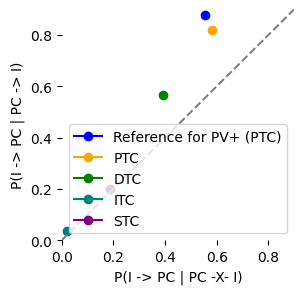

In [12]:
# Reference data as reported in:
# Znamenski et al., 2024. Neuron (112;6). Functional specificity of recurrent inhibition in visual cortex
ref = pandas.DataFrame([[0.12, 0.15], [0.09, 0.64]], columns=[False, True], index=[False, True])

def rc_bias(res):
    rc_tst = res[True] / res.sum(axis=1)
    return rc_tst # [True] / rc_tst[False]
    
def bias_for_type(c_ab, c_ba, cutoff):
    c_df = pandas.DataFrame({"A -> B": c_ab > 0, "B -> A": c_ba > cutoff})
    data = c_df.value_counts(normalize=True).sort_index().unstack("B -> A")
    return rc_bias(data)

cols = ["orange", "green", "teal" , "purple"]
data_bias = pandas.concat([
    bias_for_type(*sample_pairs_within(grp_pc, [_cls], 50.0), 0) for _cls in grp_inh
], keys=grp_inh, axis=1)
    
ref_bias = rc_bias(ref)

fig = plt.figure(figsize=(3, 3))
ax = fig.gca()

ax.plot(ref_bias[False], ref_bias[True], marker='o', color='blue', label="Reference for PV+ (PTC)")
for tp, col in zip(data_bias.columns, cols):
    ax.plot(data_bias[tp][False], data_bias[tp][True], marker='o', color=col, label=tp)
ax.set_xlim([0.0, 0.9]); ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), color="grey", ls="--")
plt.legend()
ax.set_xlabel("P(I -> PC | PC -X- I)")
ax.set_ylabel("P(I -> PC | PC -> I)")
ax.set_frame_on(False)

fig.savefig("plots/compare_to_neuron_paper.pdf")

In [13]:
# Compare overall PC to PTC connection probability. Hint: It is a bit lower in Microns.
display(ref.sum(axis=1))
a, b = sample_pairs_within(grp_pc, ["PTC"], 50.0)
(a > 0).mean()

False    0.27
True     0.73
dtype: float64

0.4690522243713733